## The 2D diffusion equation on GPUs, in minutes

This notebook implements, for a given initial density profile, a solver for the 2D diffusion equation using an explicit finite difference scheme with 'do-nothing' conditions on the boundaries (and hence will not provide a reasonable solution once the profile has diffused to a boundary).

In [1]:
# Some imports we will need below
import numpy as np
from devito import *
import matplotlib.pyplot as plt 
%matplotlib inline

### Solver implementation

We start by creating a Cartesian `Grid` representing the computational domain:

In [2]:
nx, ny = 100, 100
grid = Grid(shape=(nx, ny))

To represent the density, we use a `TimeFunction` -- a scalar, discrete function encapsulating space- and time-varying data. We also use a `Constant` for the diffusion coefficient.

In [3]:
u = TimeFunction(name='u', grid=grid, space_order=2, save=200)
c = Constant(name='c')

The 2D diffusion equation is expressed as:

In [4]:
eqn = Eq(u.dt, c * u.laplace)

From this diffusion equation we derive our time-marching method -- at each timestep, we compute `u` at timestep `t+1`, which in the Devito language is represented by `u.forward`. Hence:

In [5]:
step = Eq(u.forward, solve(eqn, u.forward))

OK, it's time to let Devito generate code for our solver!

In [6]:
op = Operator([step])

Before executing the `Operator` we must first specify the initial density profile. Here, we place a "ring" with a constant density value in the center of the domain.

In [7]:
xx, yy = np.meshgrid(np.linspace(0., 1., nx, dtype=np.float32),
                     np.linspace(0., 1., ny, dtype=np.float32))
r = (xx - .5)**2. + (yy - .5)**2.
# Inserting the ring
u.data[0, np.logical_and(.05 <= r, r <= .1)] = 1.

We're now ready to execute the `Operator`. We run it with a diffusion coefficient of 0.5 and for a carefully chosen `dt`. Unless specified otherwise, the simulation runs for 199 timesteps as specified in the definition of `u` (i.e. the function was defined with `save=200` the initial data + 199 new timesteps).

In [8]:
stats = op.apply(dt=5e-05, c=0.5)

Operator `Kernel` ran in 0.01 s


### Initial conditions and snapshots every 40 timesteps

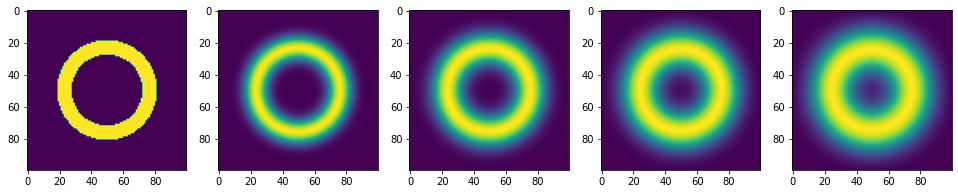

In [9]:
plt.rcParams['figure.figsize'] = (20, 20)
for i in range(1, 6):
    plt.subplot(1, 6, i)
    plt.imshow(u.data[(i-1)*40])
plt.show()

### GPU-parallel solver

Let us now generate a GPU implementation of the same solver. It's actually straightforward!

In [10]:
# Instead of `platform=nvidiaX`, you may run your Python code with
# the environment variable `DEVITO_PLATFORM=nvidiaX`

# We also need the `gpu-fit` option to tell Devito that `u` will definitely
# fit in the GPU memory. This is necessary every time a TimeFunction with
# `save != None` is used. Otherwise, Devito could generate code such that
# `u` gets streamed between the CPU and the GPU, but for this advanced 
# feature you will need `devitopro`.
op = Operator([step], platform='nvidiaX', opt=('advanced', {'gpu-fit': u}))

**That's it!** We can now run it exactly as before

In [11]:
# Uncomment and run only if Devito was installed with GPU support.
# stats = op.apply(dt=5e-05, c=0.5)

We should see a big performance difference between the two runs. We can also inspect `op` to see what Devito has generated to run on the GPU

In [12]:
print(op)

#define _POSIX_C_SOURCE 200809L
#define START_TIMER(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP_TIMER(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "omp.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
} ;


int Kernel(const float c, const float dt, const float h_x, const float h_y, struct dataobj *restrict u_vec, const int time_M, const int time_m, const int x_M, const int x_m, const int y_M, const int y_m, const int devicerm, const int deviceid, struct profiler * timers)
{
  /* Begin of OpenMP setup */
  if (deviceid != -1)
  {
    omp_set_default_device(deviceid);
  }
  /* End of OpenMP setup */

  float (*restrict u)[u_vec->size[1]][u_vec->